# Shapley value of features

Shapley value is a game theory tool allowing one to determine how much an agent contributes to a payoff game. It can be applied in machine learning to interpret each feature importance.

In [1]:
import pandas as pd
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Data gathering
df = pd.read_csv('triple_res.txt')
df['features'] = df['features'].apply(lambda s: s[1:])
df.head()

,features,Sen_DD,Sen_std_DD,Sen_CO,Sen_std_CO,Sen_TD,Sen_std_TD,Spe_DD,Spe_std_DD,Spe_CO,Spe_std_CO,Spe_TD,Spe_std_TD,geom_mean,geom_mean_std
0,000000010,0.2700,0.000000,0.7030,0.032078,0.5700,0.000000,0.7682,0.060023,0.3840,0.011489,0.6600,0.000000,0.525522,0.000000
1,000000011,0.8300,0.000000,0.4956,0.014988,0.5000,0.000000,0.6000,0.000000,0.5452,0.004996,0.6604,0.009992,0.595135,0.000000
2,000000100,0.6330,0.011705,0.4080,0.010954,0.5090,0.038013,0.5764,0.018629,0.4512,0.025428,0.5102,0.021586,0.509256,0.019183
3,000000101,0.6744,0.011859,0.5100,0.021817,0.5594,0.031900,0.6310,0.017578,0.5556,0.021275,0.5516,0.017362,0.577791,0.019417
4,000000110,0.5624,0.012257,0.5008,0.037515,0.6282,0.013068,0.5048,0.018787,0.5752,0.020999,0.6222,0.009009,0.563351,0.016657


In [3]:
lookup_results = {}
for ftr, sen_dd, a, sen_co, _, sen_td, _, spe_dd, b, spe_co, _, spe_td, _, geom, _ in array(df):
    lookup_results[ftr] = [sen_dd, sen_co, sen_td, spe_dd, spe_co, spe_td, geom]
lookup_results['0'*9] = [0]*7
lookup_results['0'*8 + '1'] = [0]*7

In [4]:
# Factorial function
def fact(n):
    if n not in fact.memoize:
        fact.memoize[n] = fact(n - 1)*n
    return fact.memoize[n]
fact.memoize = {0: 1}

In [5]:
# binary(n) converts n into a binary string
# useful to enumerate feature combinations
def binary_rec(n):
    if n not in binary_rec.memoize:
        binary_rec.memoize[n] = binary_rec(n // 2) + str(n % 2)
    return binary_rec.memoize[n]
binary_rec.memoize = {0: '0', 1: '1'}

def binary(n, l):
    if (n, l) not in binary.memoize:        
        b = binary_rec(n)
        binary.memoize[(n, l)] = '0'*(l - len(b)) + b
    return binary.memoize[(n, l)]
binary.memoize = {}

def binary_set(n):
    if n not in binary_set_memoize:
        binary_set_memoize[n] = [
            binary(i, n) for i in range(2**n)
        ]
    return binary_set_memoize[n]
binary_set_memoize = {}

def weight(bin_str):
    if bin_str not in weight_memoize:
        weight_memoize[bin_str] = sum(list(map(int, bin_str)))
    return weight_memoize[bin_str]
weight_memoize = {}

In [6]:
def get_joint(values, i, j, evaluation):
    assert i != j, "i and j must be different."
    value = 0
    for bin_str in binary_set(7):
        if i > j: i, j = j, i;  
        bin_str_in, bin_str_out = (
            bin_str[:i] + '1' + bin_str[i:j-1] + '1' + bin_str[j-1:],
            bin_str[:i] + '0' + bin_str[i:j-1] + '0' + bin_str[j-1:]
        )
        nu = max(0, values[bin_str_in][evaluation] - values[bin_str_out][evaluation])
        S = weight(bin_str)
        value += fact(S)*fact(7 - S)*nu
    return value/fact(8)

def get_marginal(values, i, j, evaluation):
    """ i: in, j: out """
    assert i != j, "i and j must be different."
    value = 0
    for bin_str in binary_set(7):
        a, b = min(i, j), max(i, j)
        bin_str_in, bin_str_out = (
            bin_str[:a] + 'a' + bin_str[a:b-1] + 'b' + bin_str[b-1:],
            bin_str[:a] + '0' + bin_str[a:b-1] + '0' + bin_str[b-1:]
        )
        if i == a:
            bin_str_in = bin_str_in.replace('a', '1').replace('b', '0')
        else:
            bin_str_in = bin_str_in.replace('a', '0').replace('b', '1')
        nu = max(0, values[bin_str_in][evaluation] - values[bin_str_out][evaluation])
        S = weight(bin_str)
        value += fact(S)*fact(7 - S)*nu
    return value/fact(8)          

In [7]:
def get_interaction(values, i, j, evaluation):
    return (
        get_joint(values, i, j, evaluation) - 
        get_marginal(values, i, j, evaluation) -
        get_marginal(values, j, i, evaluation)
    )

In [8]:
def get_shapley(values, i, evaluation):
    value = 0
    for bin_str in binary_set(8):
        bin_str_in, bin_str_out = (
            bin_str[:i] + '1' + bin_str[i:],
            bin_str[:i] + '0' + bin_str[i:]
        )
        nu = max(0, values[bin_str_in][evaluation] - values[bin_str_out][evaluation])
        S = weight(bin_str)
        value += fact(S)*fact(9 - S)*nu
    return value/fact(9)

In [52]:
e = 1

shap1 = [get_shapley(lookup_results, i, e) for i in range(9)]
shap1 = shap1/sum(shap1)

In [53]:
for e in range(7):
    print([get_shapley(lookup_results, i, e) for i in range(9)])

[1.4148722222222216, 0.16029999999999994, 0.95665079365079386, 0.37452619047619068, 1.072379365079366, 0.21712777777777792, 1.0853992063492066, 0.63705158730158751, 0.39629047619047619]
[0.61524841269841257, 0.12348015873015886, 0.52493333333333358, 0.57747222222222216, 0.89726031746031754, 0.21924047619047646, 0.75029126984127026, 0.90843968253968188, 0.45114126984127007]
[0.82329523809523875, 0.80908492063492077, 0.69765952380952345, 0.90907619047619037, 0.60724999999999951, 0.97820238095238143, 0.83004365079364983, 0.88960634920634929, 0.10857380952380948]
[1.2811730158730157, 0.19680555555555557, 0.70175634920634955, 0.65070714285714226, 0.96574761904761919, 0.72300238095238123, 0.80905952380952384, 1.0501492063492064, 0.19449206349206358]
[0.59089206349206336, 0.30832619047619064, 0.52814603174603203, 0.65867539682539678, 0.82003253968253886, 0.6964849206349204, 0.84430476190476067, 0.54318571428571405, 0.37788571428571405]
[0.75328492063492081, 0.40008571428571421, 0.759157142857

In [56]:
shap1 = [0.29, 0.035, 0.14, 0.075, 0.34, 0.04, 0.165, 0.23, 0.175]
shap1 = shap1/sum(shap1)
gini= [0.25763646, 0.0112811 , 0.12601283, 0.0370286 , 0.21686219,
       0.02812521, 0.1638016 , 0.09177355, 0.06747844]

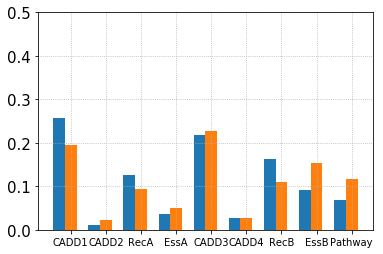

In [58]:
xs = arange(9)/2

width = 1/ 6

bar(xs, gini, width)
bar(xs+width, shap1, width)


yticks(arange(11)/10, arange(11)/10, fontsize=15)
xticks(xs + width, labels, fontsize=10)
ylim( (0, .5) )
grid(linestyle=':')

In [50]:
results = [
    array([
        [
            get_interaction(lookup_results, i, j, e) if i != j else get_shapley(lookup_results, i, e)
            for j in range(9)
        ]
        for i in range(9)
    ])
    for e in range(7)
]

for e in range(7):
    arr = results[e]
    min_s = min(arr[i, i] for i in range(9))
    max_s = max(arr[i, i] for i in range(9))
    var_s = max_s - min_s
    
    min_i = min(arr[i, j] for i in range(9) for j in range(9) if i != j)
    max_i = max(arr[i, j] for i in range(9) for j in range(9) if i != j)
    var_i = max_i - min_i
    
    mapping = lambda x: min_i + (x - min_s)/var_s*var_i
    for i in range(9):
        arr[i, i] = mapping(arr[i, i])

In [51]:
results

[array([[ 0.09967381, -0.03882738, -0.13970429, -0.0420281 , -0.07081976,
         -0.03965   , -0.1793031 , -0.08111571, -0.07630024],
        [-0.03882738, -0.1793031 , -0.02735833, -0.0238781 , -0.03441952,
         -0.02320905, -0.03040833, -0.00837714,  0.09967381],
        [-0.13970429, -0.02735833, -0.00222004, -0.06895738, -0.13676452,
         -0.04870595, -0.13337643, -0.07714167, -0.02960381],
        [-0.0420281 , -0.0238781 , -0.06895738, -0.13166601, -0.05886095,
         -0.0174    , -0.07443952, -0.04122738, -0.00200714],
        [-0.07081976, -0.03441952, -0.13676452, -0.05886095,  0.02351431,
         -0.04160405, -0.14219405, -0.08766952, -0.06753119],
        [-0.03965   , -0.02320905, -0.04870595, -0.0174    , -0.04160405,
         -0.16666641, -0.04180357, -0.01580762, -0.02423762],
        [-0.1793031 , -0.03040833, -0.13337643, -0.07443952, -0.14219405,
         -0.04180357,  0.0264095 , -0.0961731 , -0.01723143],
        [-0.08111571, -0.00837714, -0.07714167, 

In [14]:
labels = [
    'CADD1', 'CADD2', 'RecA', 'EssA',
    'CADD3', 'CADD4', 'RecB', 'EssB',
    'Pathway'
]

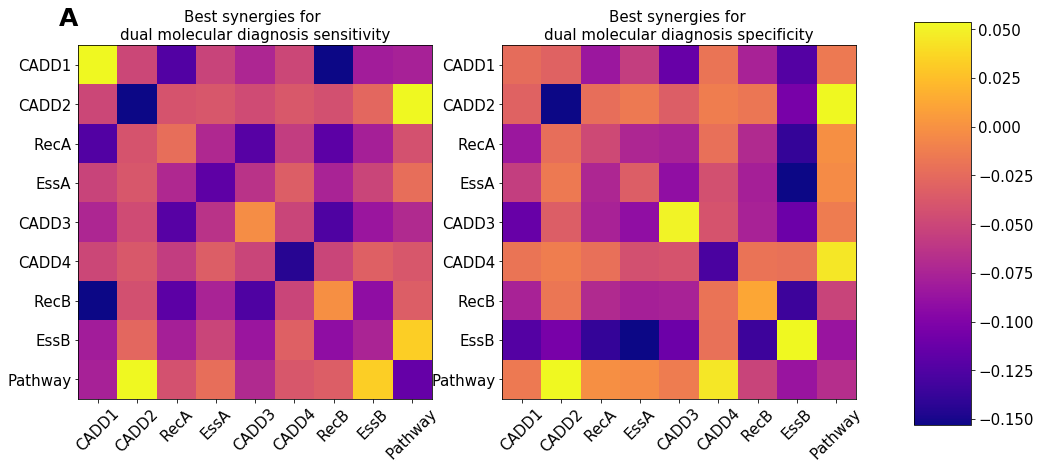

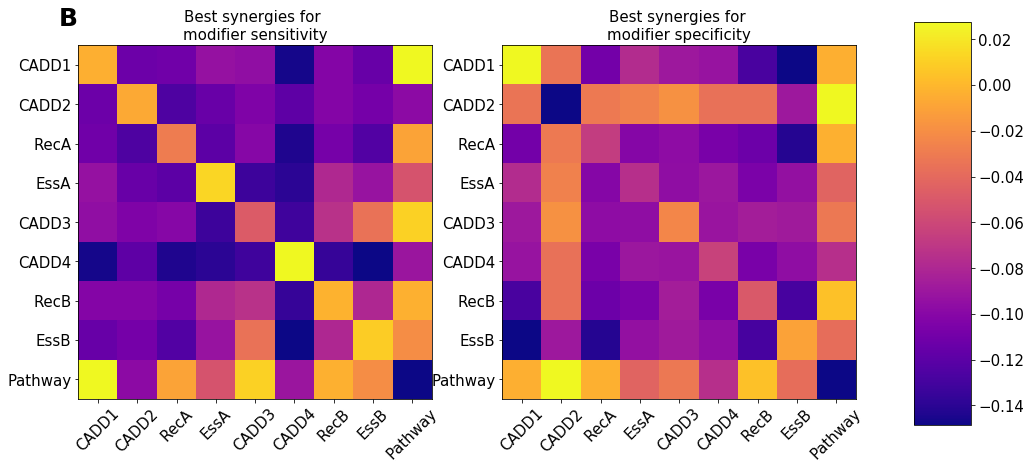

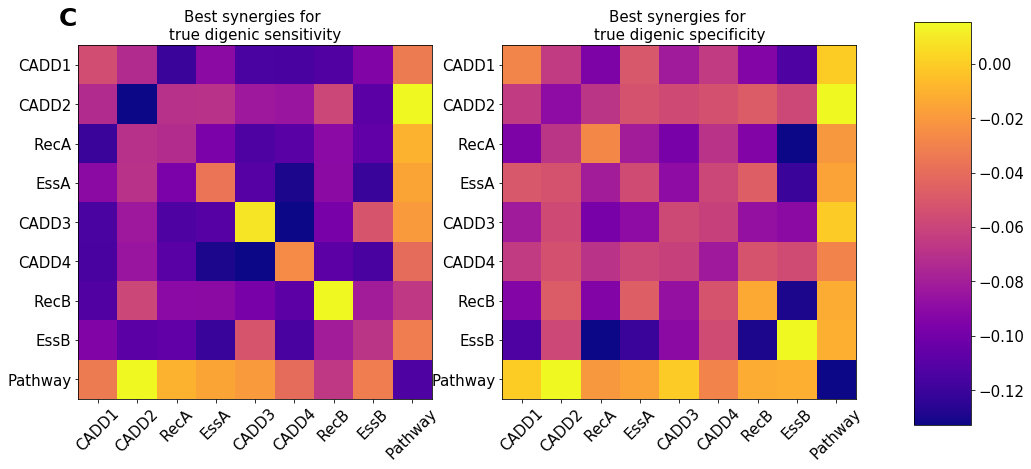

In [12]:
locs = arange(9)

for e, s, label in zip((0, 2, 4), ('dual molecular diagnosis', 'modifier', 'true digenic'), ('A', 'B', 'C')):
    fig, ax = subplots(1, 2, figsize=(16, 8))
    
    axes = ax.flat
    
    subplot(121)
    
    text(-1, -1, label, fontsize=25, weight='bold')
    imshow(results[e], cmap='plasma')    
    xticks(locs, labels, rotation=45, fontsize=15)
    yticks(locs, labels, fontsize=15)
    title('Best synergies for \n%s sensitivity' % s, fontsize=15)
    
    subplot(122)

    im = imshow(results[e+1], cmap='plasma')    
    xticks(locs, labels, rotation=45, fontsize=15)
    yticks(locs, labels, fontsize=15)
    title('Best synergies for \n%s specificity' % s, fontsize=15)
    
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.ax.tick_params(labelsize=15)
    
    savefig('exports/%s_png.png' % s.replace(" ", "_"), format='png', bbox_inches='tight')
    savefig('exports/%s_eps.eps' % s.replace(" ", "_"), format='eps', bbox_inches='tight')

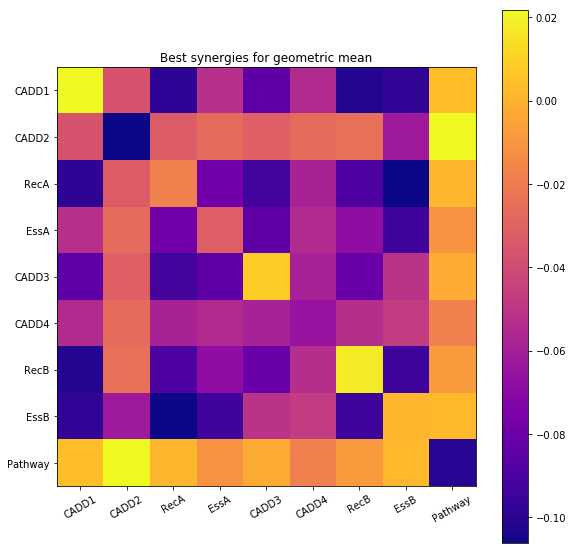

In [18]:
fig, ax = subplots(1, 1, figsize=(8, 8))
tight_layout()

subplot(1,1,1)

img = imshow(results[6], cmap='plasma')
fig.colorbar(img, cmap='plasma')

xticks(locs, labels, rotation=30)
yticks(locs, labels)

s = "geometric mean"

title('Best synergies for %s' % s)

savefig('exports/%s_png.png' % s.replace(" ", "_"), format='png')
savefig('exports/%s_eps.eps' % s.replace(" ", "_"), format='eps')

In [106]:
[round((f/i - 1)*100) for i, f in zip(lookup_results['100010000'], lookup_results['100010001'])]

[2, 27, 11, 3, 23, 13, 13]

In [4]:
lookup_results['111111110']

[0.7924, 0.4972, 0.6844, 0.756, 0.6042, 0.6186, 0.651103]

In [105]:
lookup_results['100010001']

[0.7618, 0.5364, 0.583, 0.7534, 0.5798, 0.5528, 0.621315]

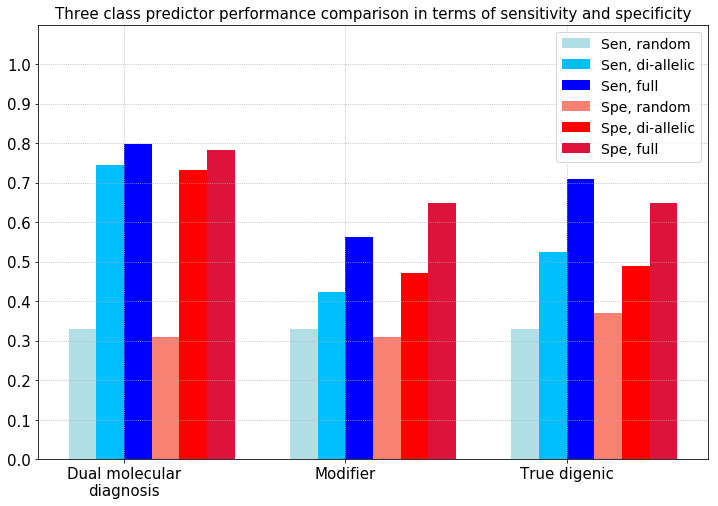

In [15]:
figure( figsize=(12, 8))

hlabels = ('Dual molecular\ndiagnosis', 'Modifier', 'True digenic')

selected = '1111110'

values_light = [ v for i, v in enumerate(lookup_results['100010000']) if selected[i] == '1' ]
values_heavy = [ v for i, v in enumerate(lookup_results['111111111']) if selected[i] == '1' ]
values_random = [0.33, 0.33, 0.33, 0.31, 0.31, 0.37]

width = 1/24

xs = arange(3)/3

bar(xs, values_random[:3], width, color='powderblue', label='Sen, random')
bar(xs + width, values_light[:3], width, color='deepskyblue', label='Sen, di-allelic')
bar(xs + 2*width, values_heavy[:3], width, color='blue', label='Sen, full')
bar(xs + 3*width, values_random[3:], width, color='salmon', label='Spe, random')
bar(xs + 4*width, values_light[3:], width, color='red', label='Spe, di-allelic')
bar(xs + 5*width, values_heavy[3:], width, color='crimson', label='Spe, full')

yticks(arange(11)/10, arange(11)/10, fontsize=15)
xticks(xs + 1.5*width, hlabels, fontsize=15)
ylim( (0, 1.1) )
grid(linestyle=':')

legend(prop={'size': 14})
title('Three class predictor performance comparison in terms of sensitivity and specificity', fontsize=15)

savefig('exports/pred_results_png.png', format='png')
savefig('exports/pred_results_eps.eps', format='eps', bbox_inches='tight')

In [28]:
values_light

[0.7438, 0.4236, 0.5236, 0.731, 0.4716, 0.4898]